# Experiment Size

We can use the knowledge of our desired practical significance boundary to plan out our experiment. By knowing how many observations we need in order to detect our desired effect to our desired level of reliability, we can see how long we would need to run our experiment and whether or not it is feasible.

Let's use the example from the video, where we have a baseline click-through rate of 10% and want to see a manipulation increase this baseline to 12%. How many observations would we need in each group in order to detect this change with power $1-\beta = .80$ (i.e. detect the 2% absolute increase 80% of the time), at a Type I error rate of $\alpha = .05$?

In [1]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

%matplotlib inline

## Method 1: Trial and Error

One way we could solve this is through trial and error. Every sample size will have a level of power associated with it; testing multiple sample sizes will gradually allow us to narrow down the minimum sample size required to obtain our desired power level. This isn't a particularly efficient method, but it can provide an intuition for how experiment sizing works.

Fill in the `power()` function below following these steps:

1. Under the null hypothesis, we should have a critical value for which the Type I error rate is at our desired alpha level.
  - `se_null`: Compute the standard deviation for the difference in proportions under the null hypothesis for our two groups. The base probability is given by `p_null`. Remember that the variance of the difference distribution is the sum of the variances for the individual distributions, and that _each_ group is assigned `n` observations.
  - `null_dist`: To assist in re-use, this should be a [scipy norm object](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html). Specify the center and standard deviation of the normal distribution using the "loc" and "scale" arguments, respectively.
  - `p_crit`: Compute the critical value of the distribution that would cause us to reject the null hypothesis. One of the methods of the `null_dist` object will help you obtain this value (passing in some function of our desired error rate `alpha`).
2. The power is the proportion of the distribution under the alternative hypothesis that is past that previously-obtained critical value.
  - `se_alt`: Now it's time to make computations in the other direction. This will be standard deviation of differences under the desired detectable difference. Note that the individual distributions will have different variances now: one with `p_null` probability of success, and the other with `p_alt` probability of success.
  - `alt_dist`: This will be a scipy norm object like above. Be careful of the "loc" argument in this one. The way the `power` function is set up, it expects `p_alt` to be greater than `p_null`, for a positive difference.
  - `beta`: Beta is the probability of a Type-II error, or the probability of failing to reject the null for a particular non-null state. That means you should make use of `alt_dist` and `p_crit` here!

The second half of the function has already been completed for you, which creates a visualization of the distribution of differences for the null case and for the desired detectable difference. Use the cells that follow to run the function and observe the visualizations, and to test your code against a few assertion statements. Check the following page if you need help coming up with the solution.

In [2]:
def power(p_null, p_alt, n, alpha=0.05, alternative="one-sided", plot=True):
    """power computes the power of detecting the difference in two populations with different proportion parameters, given a desired alpha rate.

    Args:
        p_null (float, required): base success rate under null hypothesis.
        p_alt (float, required): desired success rate to be detected.
        n (int, required): sample size for each group.
        alpha (float, optional): Type-I error rate (FP). Defaults to .05.
        alternative (str, optional): Enum from "one-sided" and "two-sided". Defautls to "one-sided".
        plot (bool, optional): whether or not draw density curves.

    Returns:
        float : Type-II error rate (FN).
    """

    # Wald test: https://en.wikipedia.org/wiki/Wald_test
    # critical value of the standard normal distribution for the desired significance level
    if alternative == "two-sided":
        z_a = stats.norm.ppf(1 - alpha / 2)
    elif alternative == "one-sided":
        z_a = stats.norm.ppf(1 - alpha)

    # z-score
    # z = (z_a + z_b) ** 2
    # effect size
    es = abs(p_alt - p_null)
    # variance
    variance = (p_null * (1 - p_null) + p_alt * (1 - p_alt)) / es**2
    # compute and return beta, according to z-score
    z = n / variance
    z_b = np.sqrt(z) - z_a
    beta = stats.norm.cdf(-z_b)

    if plot:
        # define distributions
        se_null = np.sqrt(p_null * (1 - p_null) / n)
        dist_null = stats.norm(p_null, se_null)
        se_alt = np.sqrt(p_alt * (1 - p_alt) / n)
        dist_alt = stats.norm(p_alt, se_alt)
        # critical value
        p_crit = dist_null.ppf(1 - alpha)
        # compute distribution heights
        low_bound = dist_null.ppf(0.01)
        high_bound = dist_alt.ppf(0.99)
        x = np.linspace(low_bound, high_bound, 201)
        y_null = dist_null.pdf(x)
        y_alt = dist_alt.pdf(x)

        # Plot the distributions
        plt.plot(x, y_null)
        plt.plot(x, y_alt)
        plt.vlines(
            p_crit,
            0,
            np.amax([dist_null.pdf(p_crit), dist_alt.pdf(p_crit)]),
            linestyles="--",
        )
        plt.fill_between(x, y_null, 0, where=(x >= p_crit), alpha=0.5)
        plt.fill_between(x, y_alt, 0, where=(x <= p_crit), alpha=0.5)

        plt.legend(["null", "alt"])
        plt.xlabel("difference")
        plt.ylabel("density")
        # annotate and mark the critical value
        plt.annotate(
            text=f"critical value\n{round(p_crit, 3)}",
            xy=(p_crit, dist_alt.pdf(p_crit) / 2),
            xytext=(p_crit, dist_alt.pdf(p_crit) / 2),
        )

        plt.show()

    return 1 - beta

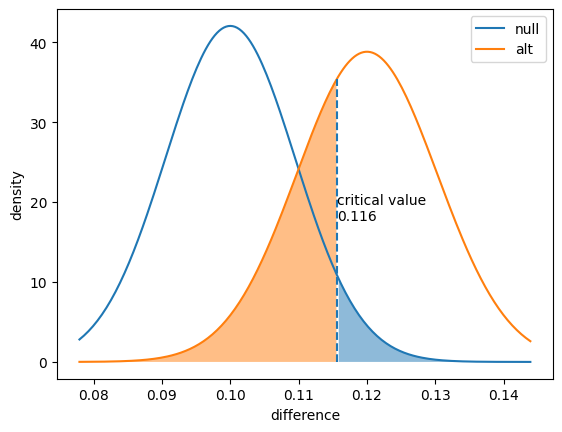

0.4149529573405426

In [3]:
# power = .41
power(0.1, 0.12, 1000, 0.05, "one-sided", True)

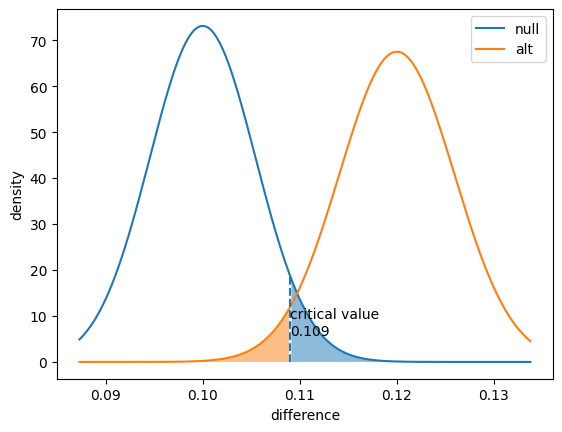

0.8000839708155107

In [4]:
# power = .8
power(0.1, 0.12, 3024, 0.05, "one-sided", True)

## Method 2: Analytic Solution

Now that we've got some intuition for power by using trial and error, we can now approach a closed-form solution for computing a minimum experiment size. The key point to notice is that, for an $\alpha$ and $\beta$ both < .5, the critical value for determining statistical significance will fall between our null click-through rate and our alternative, desired click-through rate. So, the difference between $p_0$ and $p_1$ can be subdivided into the distance from $p_0$ to the critical value $p^*$ and the distance from $p^*$ to $p_1$.

<img src= 'images/ExpSize_Power.png'>

Those subdivisions can be expressed in terms of the standard error and the z-scores:

$$p^* - p_0 = z_{1-\alpha} SE_{0},$$
$$p_1 - p^* = -z_{\beta} SE_{1};$$

$$p_1 - p_0 = z_{1-\alpha} SE_{0} - z_{\beta} SE_{1}$$

In turn, the standard errors can be expressed in terms of the standard deviations of the distributions, divided by the square root of the number of samples in each group:

$$SE_{0} = \frac{s_{0}}{\sqrt{n}},$$
$$SE_{1} = \frac{s_{1}}{\sqrt{n}}$$

Substituting these values in and solving for $n$ will give us a formula for computing a minimum sample size to detect a specified difference, at the desired level of power:

$$n = \lceil \big(\frac{z_{\alpha} s_{0} - z_{\beta} s_{1}}{p_1 - p_0}\big)^2 \rceil$$

where $\lceil ... \rceil$ represents the ceiling function, rounding up decimal values to the next-higher integer. Implement the necessary variables in the function below, and test them with the cells that follow.

In [5]:
def experiment_size(p_null, p_alt, alpha=0.05, beta=0.20, alternative="one-sided"):
    """experiment_size computes the minimum required number for each sample group needed to achieve a desired power
    level for a given effect size.

    Args:
        p_null (float, required): base success rate under null hypothesis.
        p_alt (float, required): desired success rate to be detected.
        alpha (float, optional): Type-I error rate (FP). Defaults to .05.
        beta (float, optional): Type-II error rate (FN). Defaults to .20.
        alternative (str, optional): Enum from "one-sided" and "two-sided". Defautls to "one-sided".

    Returns:
        int : Number of samples required for each group to obtain desired power.
    """

    # Wald test: https://en.wikipedia.org/wiki/Wald_test
    # critical value of the standard normal distribution for the desired significance level
    if alternative == "two-sided":
        z_a = stats.norm.ppf(1 - alpha / 2)
    elif alternative == "one-sided":
        z_a = stats.norm.ppf(1 - alpha)
    # critical value of the standard normal distribution for the desired power level
    z_b = stats.norm.ppf(1 - beta)

    # z-score
    z = (z_a + z_b) ** 2
    # effect size
    es = abs(p_alt - p_null)
    # variance
    variance = (p_null * (1 - p_null) + p_alt * (1 - p_alt)) / es**2
    # compute and return minimum sample size
    n = z * variance

    return np.ceil(n)

In [6]:
experiment_size(0.1, 0.12)

3024.0

## Notes on Interpretation

The example explored above is a one-tailed test, with the alternative value greater than the null. The power computations performed in the first part will _not_ work if the alternative proportion is less than the null, e.g. detecting a proportion parameter of 0.88 against a null of 0.9. You might want to try to rewrite the code to handle that case! The same issue should not show up for the second approach, where we directly compute the sample size.

If you find that you need to do a two-tailed test, you should pay attention to two main things. First of all, the "alpha" parameter needs to account for the fact that the rejection region is divided into two areas. Secondly, you should perform the computation based on the worst-case scenario, the alternative case with the highest variability. Since, for the binomial, variance is highest when $p = .5$, decreasing as $p$ approaches 0 or 1, you should choose the alternative value that is closest to .5 as your reference when computing the necessary sample size.

Note as well that the above methods only perform sizing for _statistical significance_, and do not take into account _practical significance_. One thing to realize is that if the true size of the experimental effect is the same as the desired practical significance level, then it's a coin flip whether the mean will be above or below the practical significance bound. This also doesn't even consider how a confidence interval might interact with that bound. In a way, experiment sizing is a way of checking on whether or not you'll be able to get what you _want_ from running an experiment, rather than checking if you'll get what you _need_.

## Alternative Approaches

### Python

There are also tools and Python packages that can also help with sample sizing decisions, so you don't need to solve for every case on your own. The sample size calculator [here](http://www.evanmiller.org/ab-testing/sample-size.html) is applicable for proportions, and provides the same results as the methods explored above. (Note that the calculator assumes a two-tailed test, however.) Python package "statsmodels" has a number of functions in its [`power` module](https://www.statsmodels.org/stable/stats.html#power-and-sample-size-calculations) that perform power and sample size calculations. Unlike previously shown methods, differences between null and alternative are parameterized as an effect size (standardized difference between group means divided by the standard deviation). Thus, we can use these functions for more than just tests of proportions. If we want to do the same tests as before, the [`proportion_effectsize`](http://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_effectsize.html) function computes [Cohen's h](https://en.wikipedia.org/wiki/Cohen%27s_h) as a measure of effect size. As a result, the output of the statsmodel functions will be different from the result expected above. This shouldn't be a major concern since in most cases, you're not going to be stopping based on an exact number of observations. You'll just use the value to make general design decisions.

In [7]:
# example of using statsmodels for sample size calculation
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# leave out the "nobs1" parameter to solve for it
power_analysis = NormalIndPower()
power_analysis.solve_power(
    effect_size=proportion_effectsize(0.12, 0.1),
    alpha=0.05,
    power=0.8,
    alternative="larger",
)

3020.515856462404

---

### R

In [8]:
import rpy2.robjects as robjects

# Define an R code snippet to run
r_code = f"""
power.prop.test(
    p1=.1,
    p2=.12,
    power=.8,
    alternative="one.sided",
    sig.level=.05
)
"""

# Run the R code
print(robjects.r(r_code))


     Two-sample comparison of proportions power calculation 

              n = 3025.315
             p1 = 0.1
             p2 = 0.12
      sig.level = 0.05
          power = 0.8
    alternative = one.sided

NOTE: n is number in *each* group




---

### G*Power

> [G*Power - Statistical Power Analyses for Mac and Windows](https://www.psychologie.hhu.de/arbeitsgruppen/allgemeine-psychologie-und-arbeitspsychologie/gpower)<br>
> Faul, F., Erdfelder, E., Lang, A.-G., & Buchner, A. (2007). G*Power 3: A flexible statistical power analysis program for the social, behavioral, and biomedical sciences. _Behavior Research Methods_, _39_, 175-191. [Download PDF](https://www.psychologie.hhu.de/fileadmin/redaktion/Fakultaeten/Mathematisch-Naturwissenschaftliche_Fakultaet/Psychologie/AAP/gpower/GPower3-BRM-Paper.pdf "APPLIKATION, GPower3-BRM-Paper, GPower3-BRM-Paper.pdf, 1.4 MB")<br>
> Faul, F., Erdfelder, E., Buchner, A., & Lang, A.-G. (2009). Statistical power analyses using G*Power 3.1: Tests for correlation and regression analyses. _Behavior Research Methods_, _41_, 1149-1160. [Download PDF](https://www.psychologie.hhu.de/fileadmin/redaktion/Fakultaeten/Mathematisch-Naturwissenschaftliche_Fakultaet/Psychologie/AAP/gpower/GPower31-BRM-Paper.pdf "APPLIKATION, GPower31-BRM-Paper, GPower31-BRM-Paper.pdf, 576 KB")<br>

![](https://raw.githubusercontent.com/ZacksAmber/PicGo/master/img/20230216220821.png)